In [149]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import lxml
from sklearn.model_selection import train_test_split
import statsmodels
import datetime

In [2]:
coins = pd.read_csv('DATA/consolidated_coin_data.csv')

In [79]:
# get market info for ethereum from the start of 2016 to the current day
url = "https://coinmarketcap.com/currencies/neo/historical-data/?start=20130428&end="+time.strftime("%Y%m%d")
print(url)
eth_market_info = pd.read_html(url)[0]
# convert the date string to the correct date format
eth_market_info = eth_market_info.assign(Date=pd.to_datetime(eth_market_info['Date']))
# look at the first few rows
eth_market_info.head()

https://coinmarketcap.com/currencies/neo/historical-data/?start=20130428&end=20180212


Date    Open    High     Low   Close     Volume  Market Cap
0 2018-02-11  110.45  113.19   96.78  103.40  257944000  7179000000
1 2018-02-10  117.21  122.84  104.98  110.63  355323000  7618880000
2 2018-02-09  111.99  117.65  108.84  117.57  212450000  7279310000
3 2018-02-08  104.06  117.00  104.06  112.43  546733000  6763560000
4 2018-02-07  105.13  118.50   94.94  102.50  571724000  6833700000

In [80]:
coins.tail()

Currency          Date   Open   High   Low  Close     Volume Market Cap
97251  zencash  Jun 05, 2017  10.57  19.06  8.11  19.06  3,495,730          -
97252  zencash  Jun 04, 2017   9.13  13.86  5.16  10.32     26,662          -
97253  zencash  Jun 03, 2017   9.08  17.69  5.50   9.16     23,728          -
97254  zencash  Jun 02, 2017  11.34  14.48  6.86   9.09     23,401          -
97255  zencash  Jun 01, 2017  10.75  21.80  9.67  11.33      3,196          -

In [81]:
# Read only ethereum
#eth = coins[coins.Currency == 'ethereum']
eth = eth_market_info[::-1]

In [82]:
# We only want to predict the close values at first. We need to sort the dataframe by date
eth['Date1'] = pd.to_datetime(eth.Date)

/Users/gabrielfior/miniconda3/envs/pytorch36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [83]:
eth.set_index('Date1',inplace=True)
#eth.sort_values(by=['Date1'],inplace=True)

In [84]:
eth.head()

Date      Open      High       Low     Close  Volume  \
Date1                                                                   
2016-09-09 2016-09-09  0.181483  0.558951  0.181357  0.558478    1349   
2016-09-10 2016-09-10  0.558536  0.559143  0.370960  0.391001     811   
2016-09-11 2016-09-11  0.390948  0.398459  0.372790  0.376150     879   
2016-09-12 2016-09-12  0.376312  0.376671  0.360443  0.374598    1116   
2016-09-13 2016-09-13  0.374469  0.375092  0.301766  0.309509    3337   

           Market Cap  
Date1                  
2016-09-09          -  
2016-09-10          -  
2016-09-11          -  
2016-09-12          -  
2016-09-13          -

In [85]:
close = eth.Close

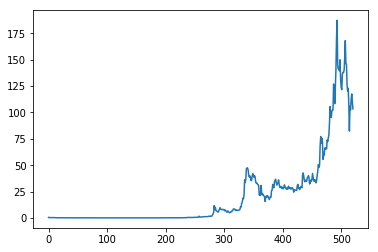

In [86]:
plt.plot(close.values)
plt.show()

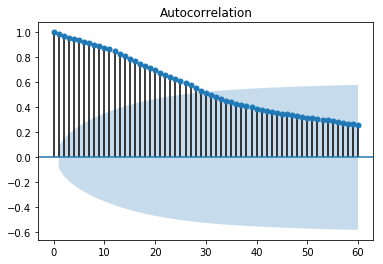

In [111]:
# Calculate autocorrelation between lagged values
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(close, lags=60)
plt.show()

In [88]:
# Let's try with 30 coefficients, representing last month

In [112]:
train, test = close[1:len(close) - 7],close[len(close) - 7:]
#train, test = train_test_split(close, test_size=0.)

In [113]:
test

Date1
2018-02-05     82.37
2018-02-06    105.95
2018-02-07    102.50
2018-02-08    112.43
2018-02-09    117.57
2018-02-10    110.63
2018-02-11    103.40
Name: Close, dtype: float64

In [114]:
# train autoregression
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
model = AR(train)

In [115]:
model_fit = model.fit()

In [116]:
window = model_fit.k_ar
print(window)

18


In [117]:
# Make predictions
predictions = model_fit.predict(start=len(train),
                                end=len(train) + len(test) - 1,
                               dynamic=True)

In [118]:
model_fit

In [119]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' %error)

Test MSE: 108.472


[]

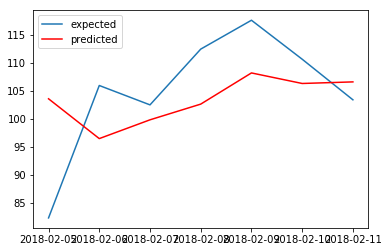

In [120]:
# plot results
plt.plot(test, label = 'expected')
plt.plot(predictions, color='red', label='predicted')
plt.legend()
plt.plot()

In [158]:
type(train)

pandas.core.series.Series

In [170]:
# Testing different apprach
# train autoregression
model = None
model = AR(train)

In [171]:
model_fit = model.fit()

In [172]:
window = model_fit.k_ar
print(window)

18


In [173]:
# walk forward over time steps in test
# last window units of train
history = train[len(train) - window:]

In [174]:
print(train.tail())
print(history)

Date1
2018-01-31    145.76
2018-02-01    126.00
2018-02-02    120.13
2018-02-03    122.97
2018-02-04    107.45
Name: Close, dtype: float64
Date1
2018-01-18    142.66
2018-01-19    139.50
2018-01-20    149.94
2018-01-21    131.09
2018-01-22    123.66
2018-01-23    121.60
2018-01-24    136.41
2018-01-25    138.00
2018-01-26    137.89
2018-01-27    140.20
2018-01-28    152.16
2018-01-29    168.14
2018-01-30    146.28
2018-01-31    145.76
2018-02-01    126.00
2018-02-02    120.13
2018-02-03    122.97
2018-02-04    107.45
Name: Close, dtype: float64


In [183]:
history = [history[i] for i in range(len(history))]

In [184]:
print(train.tail())
print(history)

Date1
2018-01-31    145.76
2018-02-01    126.00
2018-02-02    120.13
2018-02-03    122.97
2018-02-04    107.45
Name: Close, dtype: float64
[142.66, 139.5, 149.94, 131.09, 123.66, 121.6, 136.41, 138.0, 137.89, 140.2, 152.16, 168.14, 146.28, 145.76, 126.0, 120.13, 122.97, 107.45]


In [185]:
predictions = list()
for t in range(len(test)):
    
    length = len(history)
    lag = [history[i] for i in range(length - window, length)]
    print (lag)
    yhat = model_fit.params[0]
    for d in range(window):
        yhat += model_fit.params[d+1]*lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    #print('predicted=%f, expected=%f' %(yhat, obs))

error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' %error)

[142.66, 139.5, 149.94, 131.09, 123.66, 121.6, 136.41, 138.0, 137.89, 140.2, 152.16, 168.14, 146.28, 145.76, 126.0, 120.13, 122.97, 107.45]
[139.5, 149.94, 131.09, 123.66, 121.6, 136.41, 138.0, 137.89, 140.2, 152.16, 168.14, 146.28, 145.76, 126.0, 120.13, 122.97, 107.45, 82.37]
[149.94, 131.09, 123.66, 121.6, 136.41, 138.0, 137.89, 140.2, 152.16, 168.14, 146.28, 145.76, 126.0, 120.13, 122.97, 107.45, 82.37, 105.95]
[131.09, 123.66, 121.6, 136.41, 138.0, 137.89, 140.2, 152.16, 168.14, 146.28, 145.76, 126.0, 120.13, 122.97, 107.45, 82.37, 105.95, 102.5]
[123.66, 121.6, 136.41, 138.0, 137.89, 140.2, 152.16, 168.14, 146.28, 145.76, 126.0, 120.13, 122.97, 107.45, 82.37, 105.95, 102.5, 112.43]
[121.6, 136.41, 138.0, 137.89, 140.2, 152.16, 168.14, 146.28, 145.76, 126.0, 120.13, 122.97, 107.45, 82.37, 105.95, 102.5, 112.43, 117.57]
[136.41, 138.0, 137.89, 140.2, 152.16, 168.14, 146.28, 145.76, 126.0, 120.13, 122.97, 107.45, 82.37, 105.95, 102.5, 112.43, 117.57, 110.63]
Test MSE: 315.782


[]

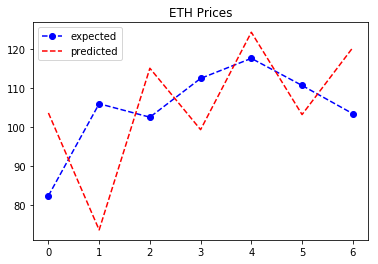

In [186]:
# plotting
plt.plot(test.values, '--bo',label = 'expected')
plt.plot(predictions, '--r', label='predicted')
plt.title('ETH Prices')
plt.legend()
plt.plot()

In [179]:
len(predictions)

1

In [180]:
list_days = []
today = datetime.datetime.now()
for day_number in range(7):
    list_days.append((today + datetime.timedelta(days=day_number+1)).date())

In [181]:
list_days

[datetime.date(2018, 2, 13),
 datetime.date(2018, 2, 14),
 datetime.date(2018, 2, 15),
 datetime.date(2018, 2, 16),
 datetime.date(2018, 2, 17),
 datetime.date(2018, 2, 18),
 datetime.date(2018, 2, 19)]

In [182]:
pd.DataFrame(list_days)

0
0  2018-02-13
1  2018-02-14
2  2018-02-15
3  2018-02-16
4  2018-02-17
5  2018-02-18
6  2018-02-19